<a href="https://colab.research.google.com/github/SidorenkArtem/Health_Insurance_Dataset/blob/master/ExtraTreesRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance (4).csv


In [2]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "insurance.csv" with length 55628 bytes


In [3]:
from keras.utils import to_categorical
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv("insurance.csv")

Преобразуем категориальные данные для упрощенной работы с ними. 

In [0]:
le = LabelEncoder()

data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['region'] = le.fit_transform(data['region'])
value = np.array(data[['region']])

encoded = to_categorical(value)
inverted = np.argmax(encoded[0])

encoded.astype(int)
data=data.drop(['region'],axis=1)
data['region_northwest']=encoded[:,0].transpose()
data['region_southeast']=encoded[:,1].transpose()
data['region_southwest']=encoded[:,2].transpose()
data['region_northeast']=encoded[:,3].transpose()

In [0]:
def visualization_result(y_test, y_pred):
  df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
  print(df)

  df1 = df.head(25)
  df1.plot(kind='bar',figsize=(16,10))
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()

In [0]:
def visualization_error(y_test, y_pred):
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Сначала я иcпользую входной массив x со всеми полями.
Произвожу разделение данных: train = 80%, test = 20%.

          Actual     Predicted
0     1646.42970   1647.000876
1    11353.22760  11346.952596
2     8798.59300   8808.090168
3    10381.47870  10386.612942
4     2103.08000   2093.283359
..           ...           ...
263  40103.89000  40102.896910
264  42983.45850  42954.317891
265  44202.65360  44261.061680
266   2136.88225   2136.940625
267   5227.98875   5219.337061

[268 rows x 2 columns]


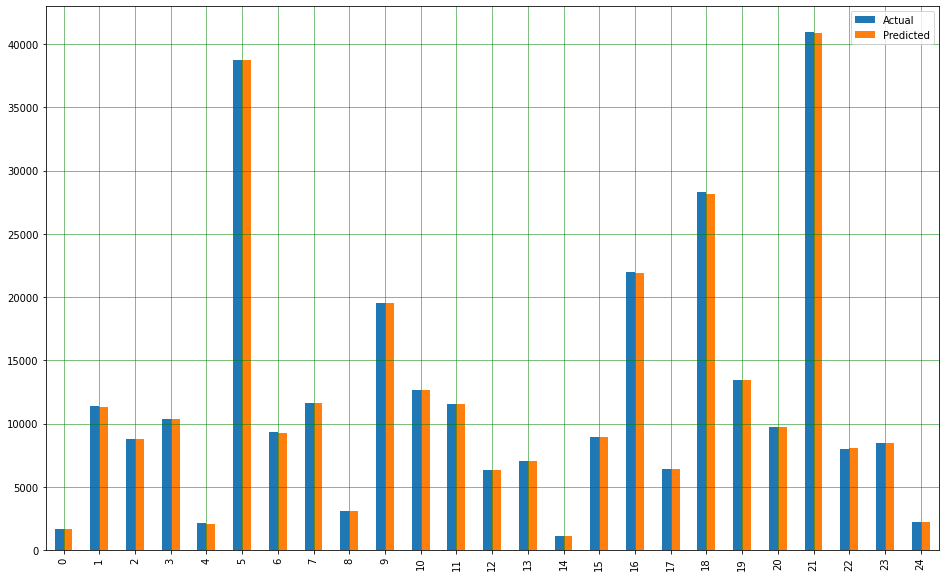

Mean Absolute Error: 38.375508453770244
Root Mean Squared Error: 122.41267866097905


In [8]:
x = data[['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
          'region_northwest', 'region_southeast', 'region_southwest',
          'region_northeast']].values

y = data['charges'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state = 1)
model = ExtraTreesRegressor()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Как можно увидеть по MSE, RMSE и графику модель сильно переобучена. Ясно то, что все поля нам не нужны. 

**Улучшение 1.** 

Попробую стандартизировать поля 'bmi', 'age', 'charges', чтобы уменьшить влияние выбросов.

          Actual     Predicted
0     1646.42970   1639.138196
1    11353.22760  11374.836871
2     8798.59300   8805.405229
3    10381.47870  10375.753414
4     2103.08000   2107.810359
..           ...           ...
263  40103.89000  40071.175130
264  42983.45850  43035.119831
265  44202.65360  44210.487561
266   2136.88225   2136.335843
267   5227.98875   5235.075020

[268 rows x 2 columns]


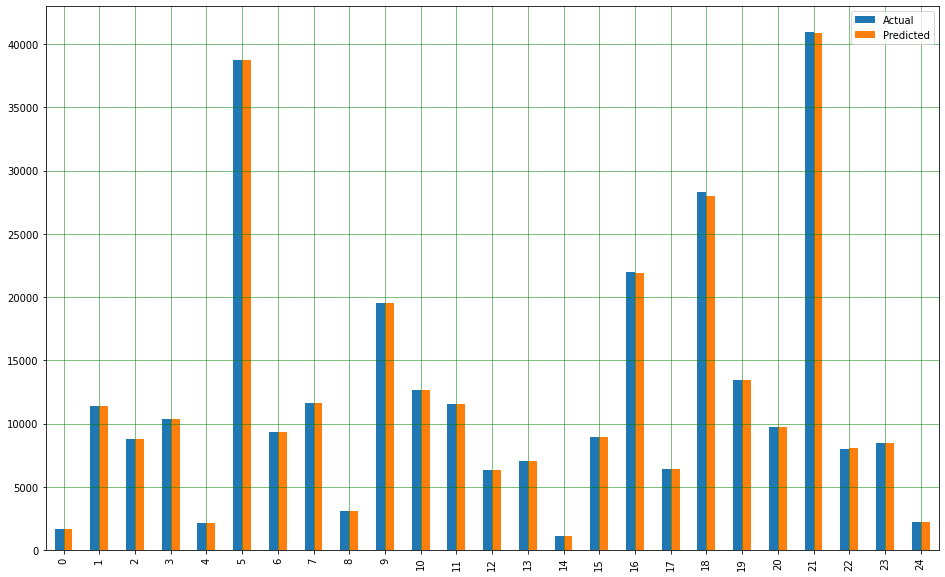

Mean Absolute Error: 50.14257872637233
Root Mean Squared Error: 231.67068844377903


In [9]:
x = data[['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
          'region_northwest', 'region_southeast', 'region_southwest',
          'region_northeast']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

model = ExtraTreesRegressor()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Явное переобучение.

**Улучшение 2**

Теперь попробую использовать в X те метки, которые оказались более важными.
В представленном ниже примере использую метки, выделенные классификатор ExtraTreesClassifier и Boruto. Это 'age', 'bmi','children', 'smoker'.

          Actual     Predicted
0     1646.42970   1348.528791
1    11353.22760  11965.633485
2     8798.59300   9522.293458
3    10381.47870  10428.371188
4     2103.08000   2479.911404
..           ...           ...
263  40103.89000  41274.598515
264  42983.45850  47812.097807
265  44202.65360  44456.904601
266   2136.88225   1775.624730
267   5227.98875   4810.292259

[268 rows x 2 columns]


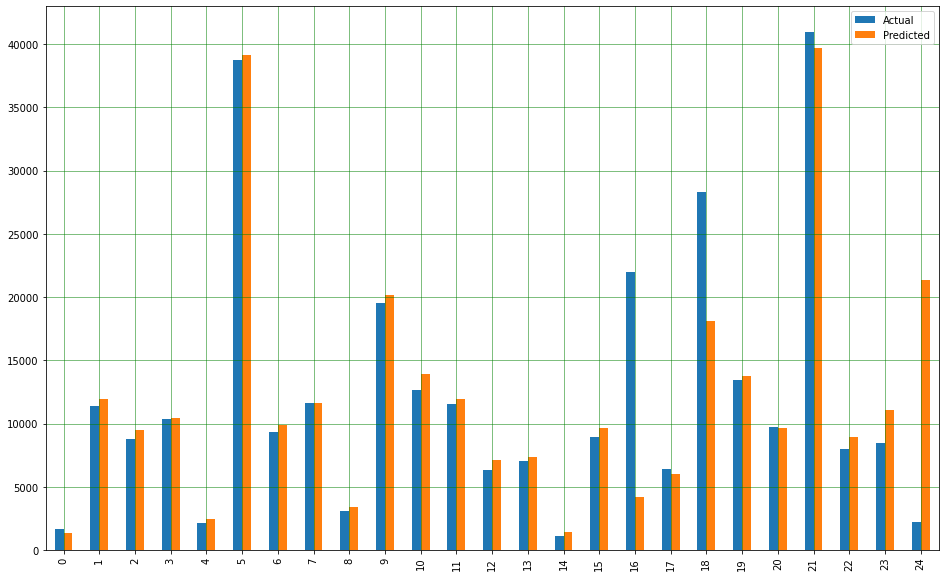

Mean Absolute Error: 2578.3667768353616
Root Mean Squared Error: 5187.698664095984


In [10]:
x = data[['age', 'bmi', 'children', 'smoker']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

model = ExtraTreesRegressor()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Из корреляционной матрицы можно выделить 'age', 'bmi', 'smoker'

          Actual     Predicted
0     1646.42970   1326.736243
1    11353.22760  11790.052728
2     8798.59300  10565.672652
3    10381.47870   8328.651644
4     2103.08000   2399.179554
..           ...           ...
263  40103.89000  41184.996201
264  42983.45850  47736.321602
265  44202.65360  45519.765523
266   2136.88225   1802.326379
267   5227.98875   4911.483615

[268 rows x 2 columns]


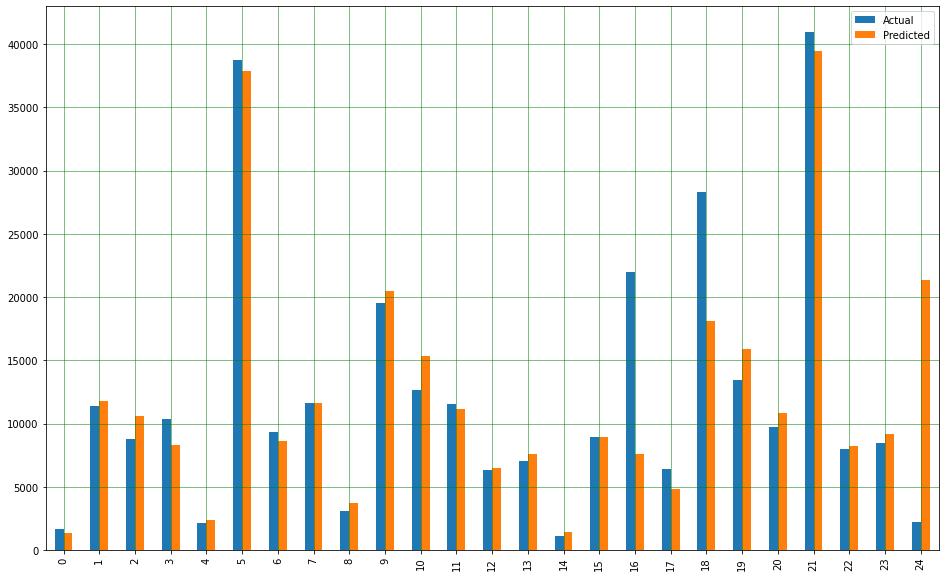

Mean Absolute Error: 3181.2096720113927
Root Mean Squared Error: 5899.8394612588145


In [11]:
x = data[['age', 'bmi', 'smoker']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

model = ExtraTreesRegressor()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

**Вывод**

В этой моделе результаты с 3-мя и 4-мя полями, по сравнению с линейной регрессией, различны. Модель с 4-мя полями будет более информативной.